- Divide each signal into epochs of 6 epochs (non-overlapping) and calculate welch's on each epoch. 
- Calculate ICC. Each group would be the first and last segment of a subject. Then we have multiple groups are there are multiple subjects. ICC is calculated  similar to calculated a correlation for the 2 segments for each subject and then averaging the correlation.
- Increase the size of the epochs to build a ICC vs epoch duration plot.
- Permute 1000 times the order of the segments per subject and repeat (as we as only evaluation the first vs last epoch).

In [1]:
from bids import BIDSLayout
import pandas as pd
import numpy as np
import scipy
import json
import pyedflib
import re
import nibabel as nb
import os
import xarray as xr

# Analysis

## Get the data

In [2]:
label_test = 'all_epi'

In [3]:
# Load the dataarray
ds = xr.open_dataset(f"./Data/{label_test}/ds_{label_test}_full.nc")
# Update text inputs
# for coord in ['subj_chn', 'group', 'chn', 'subj']:
#     ds.coords[coord] = ds.coords[coord].astype('<U32')
# for coord in ['PD', 'AP']:
#     ds.coords[coord] = ds.coords[coord].astype('float64')
ds

<xarray.Dataset>
Dimensions:           (time: 48000, n: 235, frequency: 159, f_bands: 5)
Coordinates:
  * time              (time) float64 0.0 0.005 0.01 0.015 ... 240.0 240.0 240.0
    subj_ses_run_chn  (n) object ...
    group             (n) object ...
    chn               (n) object ...
    subj              (n) object ...
    PD                (n) float64 ...
    AP                (n) float64 ...
  * n                 (n) int32 0 1 2 3 4 5 6 7 ... 228 229 230 231 232 233 234
  * frequency         (frequency) float64 0.5 1.0 1.5 2.0 ... 78.5 79.0 79.5
  * f_bands           (f_bands) object 'delta' 'theta' 'alpha' 'beta' 'gamma'
Data variables:
    time_domain       (n, time) float64 ...
    psd               (n, frequency) float64 ...
    bandpow           (n, f_bands) float64 ...

## Crop the data into epochs

In [4]:
def epoch_DataArray(DataArray: xr.DataArray, length_epochs, srate) -> xr.Dataset:
    # length_epochs: seconds
    N_epochs = length_epochs*srate
    # Get the data splitted
    data = DataArray.values
    N_groups = data.shape[-1]/N_epochs
    epochs = np.vstack(np.array_split(data, N_groups, axis=1))
    # Get coords
    new_coords = dict()
    for coord in list(DataArray.coords):
        if coord not in list(DataArray.dims):
            coord_data = np.hstack(np.repeat(DataArray[coord].values[:, np.newaxis].T, N_groups, axis=0)) #np.repeat(DataArray[coord].values, N_groups)
            new_coords[coord] = (['n'], coord_data)
    # New coord indicating epoch number
    epoch_numbers = np.arange(N_groups)  
    n_epoch = np.hstack([np.repeat(i, data.shape[0]) for i in epoch_numbers]).astype(int)
    new_coords['n_epoch'] = (['n'], n_epoch)
    # Append time and n as dims
    new_coords['time'] = np.arange(epochs.shape[-1])/srate
    new_coords['n'] = np.arange(epochs.shape[0])
    # Build dataSet
    new_ds = xr.Dataset(
        {'time_domain' : (['n', 'time'], epochs)},
        coords=new_coords
    )
    return new_ds

In [5]:
ds_epoched = epoch_DataArray(ds['time_domain'], 6, 200)
ds_epoched

<xarray.Dataset>
Dimensions:           (n: 9400, time: 1200)
Coordinates:
    subj_ses_run_chn  (n) object 'sub-003_ses-007_run-02_LAHc1-2' ... 'sub-09...
    group             (n) object 'contra_TLE' 'ipsi_TLE' ... 'ipsi_TLE'
    chn               (n) object 'LAHc1-2' 'RAHc1-2' ... 'LAHc1-2' 'LAHc2-3'
    subj              (n) object '003' '003' '003' '003' ... '095' '095' '095'
    PD                (n) float64 0.9948 0.9887 0.995 ... 0.9988 0.872 0.9988
    AP                (n) float64 0.3091 0.2321 0.2765 ... 0.301 0.2531 0.301
    n_epoch           (n) int64 0 0 0 0 0 0 0 0 0 ... 39 39 39 39 39 39 39 39 39
  * time              (time) float64 0.0 0.005 0.01 0.015 ... 5.985 5.99 5.995
  * n                 (n) int64 0 1 2 3 4 5 6 ... 9394 9395 9396 9397 9398 9399
Data variables:
    time_domain       (n, time) float64 -0.1329 -3.589 -70.32 ... 59.68 -0.1329

In [6]:
ds['time_domain'].to_numpy()[0,1198:1202]

array([109.92594797, 126.40819409, 145.01718166, 127.73740749])

In [7]:
ds_epoched['time_domain'][0:3, :]

<xarray.DataArray 'time_domain' (n: 3, time: 1200)>
array([[ -0.13292134,  -3.58887617, -70.31538872, ...,  41.60437934,
        109.92594797, 126.40819409],
       [  1.72797742,  37.88258183,  58.08662547, ..., -24.59044785,
         17.94438087,  53.8331426 ],
       [ -1.9938201 , -19.27359426,  15.28595407, ...,  80.15156786,
         34.16078431,  37.35089647]])
Coordinates:
    subj_ses_run_chn  (n) object 'sub-003_ses-007_run-02_LAHc1-2' ... 'sub-00...
    group             (n) object 'contra_TLE' 'ipsi_TLE' 'ipsi_TLE'
    chn               (n) object 'LAHc1-2' 'RAHc1-2' 'RAHc2-3'
    subj              (n) object '003' '003' '003'
    PD                (n) float64 0.9948 0.9887 0.995
    AP                (n) float64 0.3091 0.2321 0.2765
    n_epoch           (n) int64 0 0 0
  * time              (time) float64 0.0 0.005 0.01 0.015 ... 5.985 5.99 5.995
  * n                 (n) int64 0 1 2

In [8]:
ds_epoched['time_domain'][216:219, :]

<xarray.DataArray 'time_domain' (n: 3, time: 1200)>
array([[ -0.13292134,  17.14685283,  11.29831388, ..., -32.56572824,
        -35.22415503, -13.15921263],
       [ -0.13292134, -20.33696498, -22.19786374, ...,  -7.57651637,
        -14.48842603,  -3.05719081],
       [ -0.13292134,   0.6646067 ,  -7.31067369, ...,  12.89336995,
          0.93044938,  20.86865034]])
Coordinates:
    subj_ses_run_chn  (n) object 'sub-088_ses-002_run-01_LAHc2-3' ... 'sub-08...
    group             (n) object 'contra_TLE' 'contra_TLE' 'contra_TLE'
    chn               (n) object 'LAHc2-3' 'LAHc2-3' 'LAHc2-3'
    subj              (n) object '088' '088' '088'
    PD                (n) float64 0.2447 0.2447 0.2447
    AP                (n) float64 0.2689 0.2689 0.2689
    n_epoch           (n) int64 0 0 0
  * time              (time) float64 0.0 0.005 0.01 0.015 ... 5.985 5.99 5.995
  * n                 (n) int64 216 217 218

## Frequency domain

In [9]:
# Get data in frequency domain
import analysis
ds_freq = analysis.psd_xarray(ds_epoched, 200)
ds_freq

(9400, 201)


<xarray.Dataset>
Dimensions:           (n: 9400, time: 1200, frequency: 159)
Coordinates:
    subj_ses_run_chn  (n) object 'sub-003_ses-007_run-02_LAHc1-2' ... 'sub-09...
    group             (n) object 'contra_TLE' 'ipsi_TLE' ... 'ipsi_TLE'
    chn               (n) object 'LAHc1-2' 'RAHc1-2' ... 'LAHc1-2' 'LAHc2-3'
    subj              (n) object '003' '003' '003' '003' ... '095' '095' '095'
    PD                (n) float64 0.9948 0.9887 0.995 ... 0.9988 0.872 0.9988
    AP                (n) float64 0.3091 0.2321 0.2765 ... 0.301 0.2531 0.301
    n_epoch           (n) int64 0 0 0 0 0 0 0 0 0 ... 39 39 39 39 39 39 39 39 39
  * time              (time) float64 0.0 0.005 0.01 0.015 ... 5.985 5.99 5.995
  * n                 (n) int64 0 1 2 3 4 5 6 ... 9394 9395 9396 9397 9398 9399
  * frequency         (frequency) float64 0.5 1.0 1.5 2.0 ... 78.5 79.0 79.5
Data variables:
    time_domain       (n, time) float64 -0.1329 -3.589 -70.32 ... 59.68 -0.1329
    psd               (n, frequency) float64 0.3551 0.3793 ... 0.0002508

In [10]:
# Reduce dimension of frequency dataArray
def average_per_channel_epochs(DataArray: xr.DataArray, weights=False):
    new_data = np.array([])
    subj_chn = []
    new_subjs = []
    new_chns = []
    group = []
    new_n_epoch = []
    PD_coords = np.array([])
    AP_coords = np.array([])
    new_weights = np.array([])
    # Compute across subjects
    subjs = np.unique(DataArray['subj'])
    for subj in subjs:
        ds_subj = DataArray.where(DataArray['subj']==subj, drop=True)
        # Compute per epoch
        n_epochs = np.unique(ds_subj['n_epoch'])
        for n_epoch in n_epochs:
            ds_subj_epoch = ds_subj.where(ds_subj['n_epoch']==n_epoch, drop=True)
            # Compute for each channel
            # print(subj, n_epoch)
            chns = np.unique(ds_subj['chn'])
            for chn in chns:
                ds_chn = ds_subj_epoch.where(ds_subj_epoch['chn'] == chn, drop=True)
                # Get average data
                data = np.mean(ds_chn.values, axis=0)
                new_data = np.vstack([new_data.reshape(-1,len(data)), data])
                # Append coords
                subj_chn.append(f'sub-{subj}_{chn}')
                new_subjs.append(subj)
                new_chns.append(chn)
                new_n_epoch.append(n_epoch)
                group.append(str(ds_chn.group[0].values))
                PD_coords = np.hstack([PD_coords, ds_chn.PD[0]])
                AP_coords = np.hstack([AP_coords, ds_chn.AP[0]])
                if weights:
                    new_weights = np.hstack([new_weights, ds_chn.weights[0]])
    # Get old dim different to 'n'
    old_dims = list(DataArray.dims)
    old_dims.remove('n')
    old_dim = old_dims[0]
    # Build new dataarray
    ds_new = xr.Dataset(
        {'psd' : (['n', old_dim], new_data)},
        coords={
            "subj": (["n"], new_subjs),
            "chn": (["n"], new_chns),
            "group": (["n"], group),
            "subj_chn": (["n"], subj_chn),
            "PD": (["n"], PD_coords),
            "AP": (["n"], AP_coords),
            'n_epoch': (["n"], new_n_epoch),
            f"{old_dim}": DataArray[old_dim].values,
            'n': np.arange(new_data.shape[0])
        }
    )
    if weights:
        ds_new = ds_new.assign_coords(weights=('n', new_weights))
    return ds_new

In [11]:
# Collapse across clips and sessions
psd_data = average_per_channel_epochs(ds_freq['psd'])['psd']
psd_data # to QC here: n should be equal to the n in the reduced dataset * N_groups

<xarray.DataArray 'psd' (n: 1360, frequency: 159)>
array([[5.21249983e-01, 3.82057200e-01, 3.07638123e-01, ...,
        4.98402860e-04, 4.47131235e-04, 4.17664096e-04],
       [6.89078522e-01, 5.26085940e-01, 2.35249960e-01, ...,
        1.72041229e-03, 1.31224666e-03, 4.44226662e-04],
       [4.77371957e-01, 4.56008936e-01, 3.82814223e-01, ...,
        9.90248937e-04, 1.91983974e-03, 2.23212558e-03],
       ...,
       [3.45708011e-01, 3.47800534e-01, 2.17295226e-01, ...,
        7.12747248e-04, 4.67373227e-04, 5.34852074e-04],
       [4.39380036e-01, 3.86223260e-01, 4.36432649e-01, ...,
        3.76759043e-04, 4.20005334e-04, 5.16955996e-04],
       [3.87908236e-01, 4.14308330e-01, 5.02362781e-01, ...,
        4.34767109e-04, 4.20607774e-04, 4.83279823e-04]])
Coordinates:
    subj       (n) <U3 '003' '003' '003' '003' '003' ... '095' '095' '095' '095'
    chn        (n) <U9 'LAHc1-2' 'RAHc1-2' 'RAHc2-3' ... 'LAHc1-2' 'LAHc2-3'
    group      (n) <U10 'contra_TLE' 'ipsi_TLE' ... 'ipsi_TLE' 'ipsi_TLE'
    subj_chn   (n) <U17 'sub-003_LAHc1-2' ... 'sub-095_LAHc2-3'
    PD         (n) float64 0.9948 0.9887 0.995 0.3603 ... 0.9988 0.872 0.9988
    AP         (n) float64 0.3091 0.2321 0.2765 0.6129 ... 0.301 0.2531 0.301
    n_epoch    (n) int64 0 0 0 0 0 1 1 1 1 1 2 ... 35 35 36 36 37 37 38 38 39 39
  * frequency  (frequency) float64 0.5 1.0 1.5 2.0 2.5 ... 78.0 78.5 79.0 79.5
  * n          (n) int64 0 1 2 3 4 5 6 7 ... 1353 1354 1355 1356 1357 1358 1359

## ICC

In [15]:
import pingouin as pg
data = pg.read_dataset('icc')
icc = pg.intraclass_corr(data=data, targets='Wine', raters='Judge',
                         ratings='Scores').round(3)
# For me: 
# Wines are the groups, therefore, the f
# Judges are the samples labels within a group: like epoch A and B
# The scores are the PSDs vals at each f

In [16]:
icc.head() # df1 should be number of wines/f

Type              Description    ICC       F  df1  df2  pval         CI95%
0   ICC1   Single raters absolute  0.728  11.680    7   24   0.0  [0.43, 0.93]
1   ICC2     Single random raters  0.728  11.787    7   21   0.0  [0.43, 0.93]
2   ICC3      Single fixed raters  0.729  11.787    7   21   0.0  [0.43, 0.93]
3  ICC1k  Average raters absolute  0.914  11.680    7   24   0.0  [0.75, 0.98]
4  ICC2k    Average random raters  0.914  11.787    7   21   0.0  [0.75, 0.98]

In [17]:
# Get non_MTS ICC
icc_non_MTS = []
contra_MTS_array = psd_data.where(psd_data['group']=='contra_MTS', drop=True)
# Get subjects
subjs = np.unique(contra_MTS_array['subj'])
for subj in subjs:
    sub_array = contra_MTS_array.where(contra_MTS_array['subj']==subj, drop=True)
    chns = np.unique(sub_array['chn'])
    for chn in chns:
        chn_array = sub_array.where(sub_array['chn']==chn, drop=True)
        # Convert to df
        df = chn_array.to_dataframe().reset_index()
        icc = pg.intraclass_corr(data=df, targets='frequency', raters='n_epoch',
                         ratings='psd').round(3)
        icc_non_MTS.append(icc.loc[0, 'ICC'])
icc_non_MTS = np.array(icc_non_MTS)
icc_non_MTS.shape

(0,)

In [18]:
# Get MTS ICC
icc_MTS = []
ipsi_MTS_array = psd_data.where(psd_data['group']=='ipsi_MTS', drop=True)
# Get subjects
subjs = np.unique(ipsi_MTS_array['subj'])
for subj in subjs:
    sub_array = ipsi_MTS_array.where(ipsi_MTS_array['subj']==subj, drop=True)
    chns = np.unique(sub_array['chn'])
    for chn in chns:
        chn_array = sub_array.where(sub_array['chn']==chn, drop=True)
        # Convert to df
        df = chn_array.to_dataframe().reset_index()
        icc = pg.intraclass_corr(data=df, targets='frequency', raters='n_epoch',
                         ratings='psd').round(3)
        icc_MTS.append(icc.loc[0, 'ICC'])
icc_MTS = np.array(icc_MTS)
icc_MTS.shape

(0,)

In [19]:
plt_dict = {
    'icc': np.hstack([icc_non_MTS, icc_MTS]),
    'class': ['non_MTS' for i in icc_non_MTS]+['MTS' for i in icc_MTS]
}
plt_df = pd.DataFrame(plt_dict)
plt_df.head()

Empty DataFrame
Columns: [icc, class]
Index: []

<Axes: >

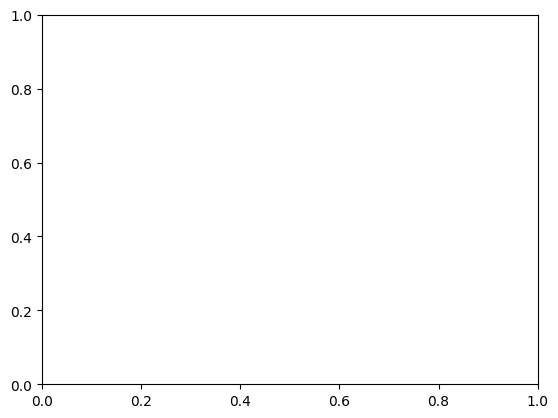

In [20]:
import seaborn as sns
sns.histplot(data=plt_df, x="icc", hue="class")

## Full Correlation

In [12]:
import math

In [13]:
def get_correlation(DataArray: xr.DataArray, identifier: str):
    # Get coords different to dims and subj, chn
    new_coords = dict()
    for coord in list(DataArray.coords):
        if coord not in list(DataArray.dims):
            new_coords[coord] = [["n"], []]
    # New coord
    new_coords['clips'] = [["n"], []]
    # New data
    corr_data = []
    # Get unique ids
    ids = np.unique(DataArray[identifier])
    for identity in ids:
        ds_chn = DataArray.where(DataArray[identifier]==identity, drop=True)
        # chns = np.unique(sub_array['chn'])
        # for chn in chns:
        #     ds_chn = sub_array.where(sub_array['chn']==chn, drop=True)
            # print(subj, chn)
            # print(ds_chn.shape)
        for i in range(ds_chn.shape[0]-1): # last element doesn't have to be corr with any segment
            for j in range(i+1, ds_chn.shape[0]):
                array_1 = ds_chn[i,:]
                array_2 = ds_chn[j,:]
                new_coords['clips'][1].append(f'clip-{i}_to_clip-{j}')
                a = np.correlate(array_1.values, array_2.values, mode='full')[(ds_chn.shape[-1]-1)]
                corr_data.append(a)
        # Append coords for all the combinations (n=data_contra_MTS.shape[0], r=2)
        comb = int(math.factorial(ds_chn.shape[0])/(math.factorial(2)*math.factorial(ds_chn.shape[0]-2)))
        for coord in new_coords:
            if coord != 'clips':
                new_coords[coord][1] += [ds_chn[coord][0].values for i in range(comb)]
    # Transform to tuple
    for coord in new_coords:
        new_coords[coord] = tuple(new_coords[coord])
    # Include new dims
    new_data = np.array(corr_data)
    new_coords['n'] = np.arange(new_data.shape[0])
    # Build new dataarray
    new_array = xr.DataArray(
        new_data,
        coords=new_coords,
        dims = ['n']
    )
    return new_array

In [14]:
corr_array = get_correlation(psd_data, 'subj_chn')
corr_array 

<xarray.DataArray (n: 26520)>
array([0.76044434, 0.90502649, 0.83544891, ..., 0.75036867, 0.81607864,
       0.72969604])
Coordinates:
    subj      (n) <U3 '003' '003' '003' '003' '003' ... '095' '095' '095' '095'
    chn       (n) <U9 'LAHc1-2' 'LAHc1-2' 'LAHc1-2' ... 'LAHc2-3' 'LAHc2-3'
    group     (n) <U10 'contra_TLE' 'contra_TLE' ... 'ipsi_TLE' 'ipsi_TLE'
    subj_chn  (n) <U17 'sub-003_LAHc1-2' 'sub-003_LAHc1-2' ... 'sub-095_LAHc2-3'
    PD        (n) float64 0.9948 0.9948 0.9948 0.9948 ... 0.9988 0.9988 0.9988
    AP        (n) float64 0.3091 0.3091 0.3091 0.3091 ... 0.301 0.301 0.301
    n_epoch   (n) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0
    clips     (n) <U18 'clip-0_to_clip-1' ... 'clip-38_to_clip-39'
  * n         (n) int64 0 1 2 3 4 5 6 ... 26514 26515 26516 26517 26518 26519

In [15]:
def get_median_corr(DataArray: xr.DataArray, identifier: str):
    # identifier: dimension that identifies the original signal before epoching (like subj_chn)
    # Get coords different to dims and subj, chn
    new_coords = dict()
    for coord in list(DataArray.coords):
        if coord not in list(DataArray.dims)+['clips']:
            new_coords[coord] = [["n"], []]
    # New data
    corr_data = []
    # Get unique 
    ids = np.unique(DataArray[identifier])
    for identity in ids:
        sub_array = DataArray.where(DataArray[identifier]==identity, drop=True)
        # chns = np.unique(sub_array['chn'])
        # for chn in chns:
        #     ds_chn = sub_array.where(sub_array['chn']==chn, drop=True)
        corr_data.append(np.median(sub_array.values, axis=0))
        # Append coords for all the combinations (n=data_contra_MTS.shape[0], r=2)
        for coord in new_coords:
            new_coords[coord][1].append(sub_array[coord][0].values)
    # Transform to tuple
    for coord in new_coords:
        new_coords[coord] = tuple(new_coords[coord])
    # Include new dims
    new_data = np.array(corr_data)
    new_coords['n'] = np.arange(new_data.shape[0])
    new_dims = ['n']
    for dim in list(DataArray.dims):
        if dim != 'n':
            new_dims.append(dim)
            new_coords[dim] = DataArray[dim].values
    # Build new dataarray
    new_array = xr.DataArray(
        new_data,
        coords=new_coords,
        dims = new_dims
    )
    return new_array

In [16]:
median_corr_array = get_median_corr(corr_array, 'subj_chn')
median_corr_array

<xarray.DataArray (n: 34)>
array([0.85246421, 0.87945675, 0.8513891 , 0.86719991, 0.88724307,
       0.83460619, 0.82652999, 0.82269537, 0.73297258, 0.74194065,
       0.77240448, 0.79850729, 0.77493379, 0.80651448, 0.78641496,
       0.77869514, 0.78617106, 0.81510744, 0.81334331, 0.82086439,
       0.80859267, 0.8472795 , 0.8348681 , 0.86051849, 0.75914089,
       0.81953305, 0.83862734, 0.83834246, 0.88123194, 0.85576594,
       0.76999483, 0.85909095, 0.83249138, 0.83736864])
Coordinates:
    subj      (n) <U3 '003' '003' '003' '003' '003' ... '083' '088' '095' '095'
    chn       (n) <U9 'LAHc1-2' 'RAHc1-2' 'RAHc2-3' ... 'LAHc1-2' 'LAHc2-3'
    group     (n) <U10 'contra_TLE' 'ipsi_TLE' ... 'ipsi_TLE' 'ipsi_TLE'
    subj_chn  (n) <U17 'sub-003_LAHc1-2' 'sub-003_RAHc1-2' ... 'sub-095_LAHc2-3'
    PD        (n) float64 0.9948 0.9887 0.995 0.3603 ... 0.2447 0.872 0.9988
    AP        (n) float64 0.3091 0.2321 0.2765 0.6129 ... 0.2689 0.2531 0.301
    n_epoch   (n) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0
  * n         (n) int64 0 1 2 3 4 5 6 7 8 9 10 ... 24 25 26 27 28 29 30 31 32 33

In [17]:
df_corr = median_corr_array.to_dataframe(name='correlation')
df_corr.head()

subj      chn       group         subj_chn        PD        AP  n_epoch  \
n                                                                           
0  003  LAHc1-2  contra_TLE  sub-003_LAHc1-2  0.994764  0.309057        0   
1  003  RAHc1-2    ipsi_TLE  sub-003_RAHc1-2  0.988714  0.232096        0   
2  003  RAHc2-3    ipsi_TLE  sub-003_RAHc2-3  0.994953  0.276491        0   
3  003  RPHc1-2    ipsi_TLE  sub-003_RPHc1-2  0.360255  0.612866        0   
4  003  RPHc2-3    ipsi_TLE  sub-003_RPHc2-3  0.477346  0.589103        0   

   correlation  
n               
0     0.852464  
1     0.879457  
2     0.851389  
3     0.867200  
4     0.887243

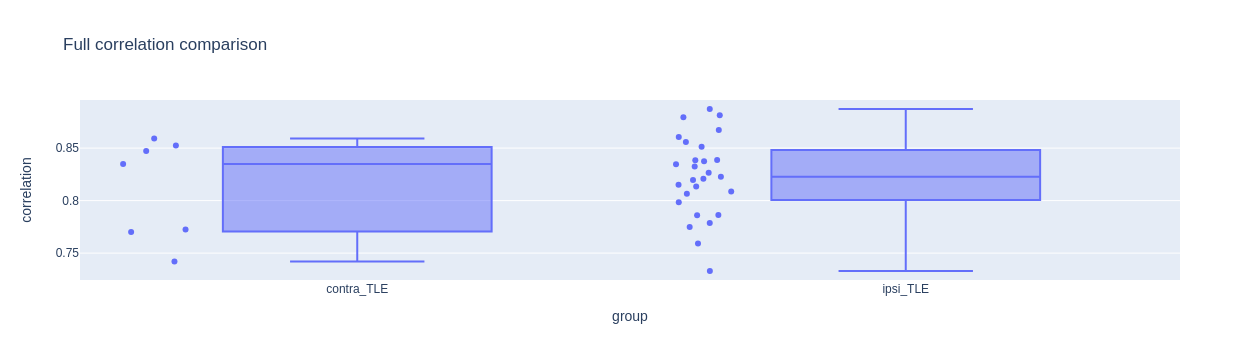

In [18]:
import plotly.express as px
os.makedirs(f'./Results/{label_test}/Corr_full/', exist_ok = True)
fig = px.box(
    df_corr, x='group', y='correlation', points="all", hover_data=['subj_chn'], title=f"Full correlation comparison"
)
fig.write_image(f'./Results/{label_test}/Corr_full/Correlation.png')
fig.show()

Interesting:
- 083 and 016 are MTS, while 003 is not (068 is MTS as well).


In [19]:
groups = np.unique(median_corr_array['group'])
median_corr_array.where(median_corr_array['group']==groups[0], drop=True).median()-median_corr_array.where(median_corr_array['group']==groups[1], drop=True).median()

<xarray.DataArray ()>
array(0.01217273)

In [20]:
import analysis
p_c, permvals = analysis.permutation_test(median_corr_array, 'group', 1000, analysis.get_median_diff_no_weights)

Median difference for true labels
Median diff: 0.012172734892445192


In [21]:
p_c

array([0.618])

### Subj level

In [22]:
# Full psd: ds_freq['psd']
ds_subj = ds_freq['psd']
subj_per_group = []
for group in np.unique(ds_subj['group']):
    subj_per_group.append((group, set(np.unique(ds_subj.where(ds_subj['group']==group, drop=True)['subj']))))

In [23]:
subjs_both = subj_per_group[0][1] & subj_per_group[1][1]
print(f'Number of subjs in the 2 groups: {len(subjs_both)} \nSubjs: {subjs_both}')

Number of subjs in the 2 groups: 1 
Subjs: {'003'}


Median difference for true labels
Median diff: -0.019256069202086
[0.139]


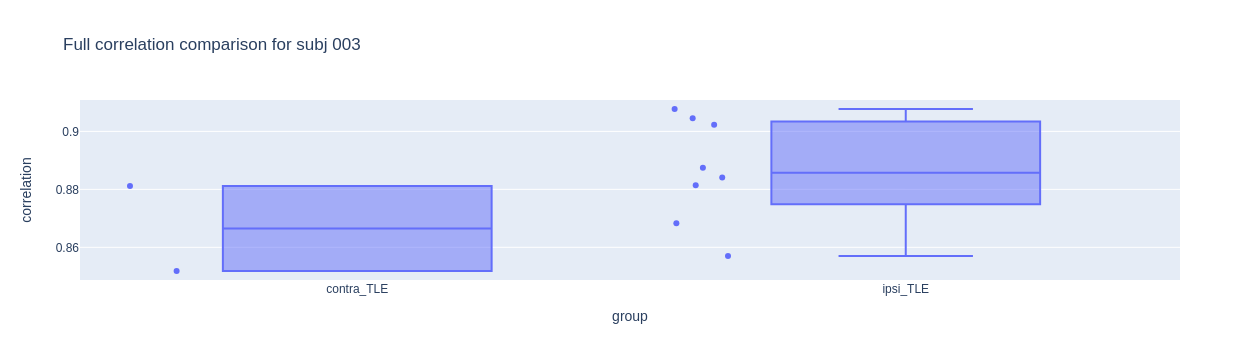

In [24]:
for subj in list(subjs_both)[0:1]:
    array_psd = ds_subj.where(ds_subj['subj']==subj, drop=True)
    # Convert to correlation between clips
    corr_array = get_correlation(array_psd, 'subj_ses_run_chn')
    # Get median correlation per channel
    median_corr_array = get_median_corr(corr_array,'subj_ses_run_chn')
    # Convert to df
    df_corr = median_corr_array.to_dataframe(name='correlation')
    fig = px.box(
        df_corr, x='group', y='correlation', points="all", hover_data=['subj_ses_run_chn'], title=f"Full correlation comparison for subj {subj}"
    )
    # Statistical diff
    p_c, permvals = analysis.permutation_test(median_corr_array, 'group', 1000, analysis.get_median_diff_no_weights)
    print(p_c)
    fig.show()

## Correlation per band

In [25]:
def get_correlation_per_band(DataArray: xr.DataArray, identifier: str):
    # Get coords different to dims and subj, chn
    new_coords = dict()
    for coord in list(DataArray.coords):
        if coord not in list(DataArray.dims):
            new_coords[coord] = [["n"], []]
    # New coord
    new_coords['clips'] = [["n"], []]
    # New data
    corr_data = []
    # Get subjects
    subjs = np.unique(DataArray['subj'])
    # Get frequency
    f = DataArray['frequency'].to_numpy()
    freq_bands = [0.5,4,8,13,30,80]
    f_bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
    # Indeces for freq bands
    freq_bands = [0.5,4,8,13,30,80]
    id_bands = []
    for i in range(len(f_bands)): 
        ind_min = np.argmax(f > freq_bands[i]) - 1
        ind_max = np.argmax(f > freq_bands[i+1]) - 1
        id_bands.append((ind_min, ind_max))
    # print(f)
    # Compute correlation
    # Get unique ids
    ids = np.unique(DataArray[identifier])
    for identity in ids:
        ds_chn = DataArray.where(DataArray[identifier]==identity, drop=True)
        # chns = np.unique(sub_array['chn'])
        # for chn in chns:
        #     ds_chn = sub_array.where(sub_array['chn']==chn, drop=True)
        comb = int(math.factorial(ds_chn.shape[0])/(math.factorial(2)*math.factorial(ds_chn.shape[0]-2)))
        tmp_corr = np.zeros((comb, 5))
        # Calculate per freq band
        k = 0
        for i in range(ds_chn.shape[0]-1): # last element doesn't have to be corr with any segment
            for j in range(i+1, ds_chn.shape[0]):
                new_coords['clips'][1].append(f'clip-{i}_to_clip-{j}')
                for p, (ind_min, ind_max) in enumerate(id_bands):
                    array_1 = ds_chn[i,ind_min: ind_max]
                    array_2 = ds_chn[j,ind_min: ind_max]
                    a = np.correlate(array_1.values, array_2.values, mode='full')[(array_1.shape[-1]-1)]
                    tmp_corr[k, p] = a
                k += 1
        corr_data.append(tmp_corr)
        # Append coords for all the combinations (n=data_contra_MTS.shape[0], r=2)
        for coord in new_coords:
            if coord != 'clips':
                new_coords[coord][1] += [ds_chn[coord][0].values for i in range(comb)]
    # Transform to tuple
    for coord in new_coords:
        new_coords[coord] = tuple(new_coords[coord])
    # Include new dims
    new_data = np.vstack(corr_data)
    new_coords['n'] = np.arange(new_data.shape[0])
    new_coords['f_bands'] = f_bands
    # Build new dataarray
    new_array = xr.DataArray(
        new_data,
        coords=new_coords,
        dims = ['n', 'f_bands']
    )
    return new_array

In [26]:
band_correlations = get_correlation_per_band(psd_data, 'subj_chn')
band_correlations # 34320

<xarray.DataArray (n: 26520, f_bands: 5)>
array([[7.46783038e-01, 1.22386436e-02, 1.10105494e-03, 2.77135077e-04,
        4.44228285e-05],
       [8.77423914e-01, 2.52601064e-02, 1.66767144e-03, 5.33946031e-04,
        1.40810443e-04],
       [8.14454624e-01, 1.89867351e-02, 1.45863613e-03, 4.66866504e-04,
        8.19537697e-05],
       ...,
       [6.88474902e-01, 5.69054439e-02, 3.51836385e-03, 1.31088022e-03,
        1.58896373e-04],
       [7.76888791e-01, 3.48206208e-02, 3.09348573e-03, 1.10349440e-03,
        1.72081158e-04],
       [6.67267189e-01, 5.47530954e-02, 5.96677110e-03, 1.51257031e-03,
        1.96155082e-04]])
Coordinates:
    subj      (n) <U3 '003' '003' '003' '003' '003' ... '095' '095' '095' '095'
    chn       (n) <U9 'LAHc1-2' 'LAHc1-2' 'LAHc1-2' ... 'LAHc2-3' 'LAHc2-3'
    group     (n) <U10 'contra_TLE' 'contra_TLE' ... 'ipsi_TLE' 'ipsi_TLE'
    subj_chn  (n) <U17 'sub-003_LAHc1-2' 'sub-003_LAHc1-2' ... 'sub-095_LAHc2-3'
    PD        (n) float64 0.9948 0.9948 0.9948 0.9948 ... 0.9988 0.9988 0.9988
    AP        (n) float64 0.3091 0.3091 0.3091 0.3091 ... 0.301 0.301 0.301
    n_epoch   (n) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0
    clips     (n) <U18 'clip-0_to_clip-1' ... 'clip-38_to_clip-39'
  * n         (n) int64 0 1 2 3 4 5 6 ... 26514 26515 26516 26517 26518 26519
  * f_bands   (f_bands) <U5 'delta' 'theta' 'alpha' 'beta' 'gamma'

In [27]:
median_band_corr = get_median_corr(band_correlations, 'subj_chn')
median_band_corr #44

<xarray.DataArray (n: 34, f_bands: 5)>
array([[8.22783022e-01, 2.09417881e-02, 2.05195016e-03, 5.70772940e-04,
        9.31486736e-05],
       [8.67033391e-01, 7.57679252e-03, 1.16635955e-03, 9.10435975e-04,
        2.49824880e-04],
       [8.07179556e-01, 2.98889620e-02, 4.83983728e-03, 2.27052476e-03,
        8.13806078e-04],
       [8.48761008e-01, 1.31766511e-02, 2.61888150e-03, 2.25008521e-03,
        1.07547728e-04],
       [8.68472401e-01, 1.26941283e-02, 1.85374541e-03, 1.98109644e-03,
        5.39511814e-04],
       [7.78253247e-01, 4.12360191e-02, 9.29470379e-03, 3.42248355e-03,
        3.11287244e-04],
       [7.12839474e-01, 8.67191631e-02, 1.99280999e-02, 4.49619160e-03,
        4.26676255e-04],
       [7.20962700e-01, 6.50395301e-02, 2.74038674e-02, 6.08903248e-03,
        4.01967617e-04],
       [6.05497403e-01, 6.88406844e-02, 3.57509546e-02, 4.30022496e-03,
        5.82475679e-03],
       [6.41300450e-01, 5.32105498e-02, 1.20191849e-02, 3.04352885e-02,
        3.61525545e-04],
...
       [6.24988795e-01, 1.03246795e-01, 2.46223875e-02, 6.22998784e-03,
        3.33013955e-05],
       [7.45581977e-01, 3.64284239e-02, 1.91817205e-02, 1.39754485e-02,
        6.39687085e-04],
       [7.51017816e-01, 4.32136962e-02, 1.86473714e-02, 2.13962606e-02,
        2.15705512e-04],
       [7.75474505e-01, 3.68730715e-02, 1.23313966e-02, 9.02615503e-03,
        1.93831307e-04],
       [8.01699715e-01, 5.85147485e-02, 1.58385563e-02, 3.71451355e-03,
        5.91637782e-06],
       [7.57840348e-01, 7.08743837e-02, 2.03195459e-02, 5.23373520e-03,
        1.44479671e-05],
       [6.78969993e-01, 6.47113891e-02, 1.99335444e-02, 4.78268011e-03,
        6.07847639e-04],
       [8.32671598e-01, 1.83082496e-02, 5.38103599e-03, 3.31047915e-03,
        2.04966579e-04],
       [7.72951579e-01, 4.99640077e-02, 6.24926372e-03, 2.20334350e-03,
        2.77887204e-04],
       [7.90364515e-01, 3.95034351e-02, 4.07055784e-03, 1.27080859e-03,
        1.67502024e-04]])
Coordinates:
    subj      (n) <U3 '003' '003' '003' '003' '003' ... '083' '088' '095' '095'
    chn       (n) <U9 'LAHc1-2' 'RAHc1-2' 'RAHc2-3' ... 'LAHc1-2' 'LAHc2-3'
    group     (n) <U10 'contra_TLE' 'ipsi_TLE' ... 'ipsi_TLE' 'ipsi_TLE'
    subj_chn  (n) <U17 'sub-003_LAHc1-2' 'sub-003_RAHc1-2' ... 'sub-095_LAHc2-3'
    PD        (n) float64 0.9948 0.9887 0.995 0.3603 ... 0.2447 0.872 0.9988
    AP        (n) float64 0.3091 0.2321 0.2765 0.6129 ... 0.2689 0.2531 0.301
    n_epoch   (n) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0
  * n         (n) int64 0 1 2 3 4 5 6 7 8 9 10 ... 24 25 26 27 28 29 30 31 32 33
  * f_bands   (f_bands) <U5 'delta' 'theta' 'alpha' 'beta' 'gamma'

In [28]:
import os
os.makedirs(f'./Results/{label_test}/corr_band/', exist_ok = True)

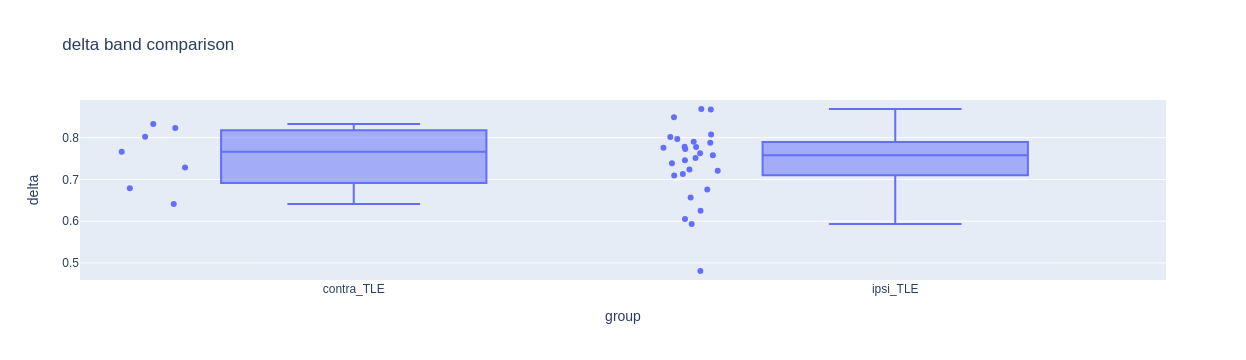

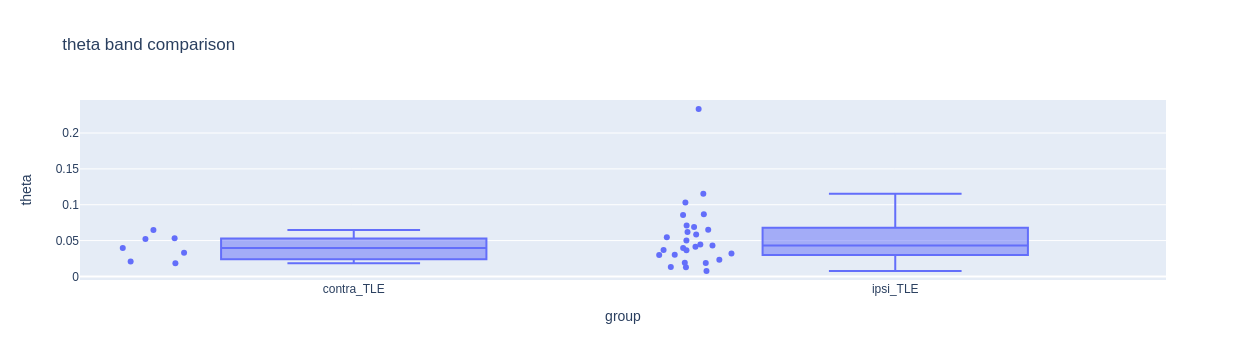

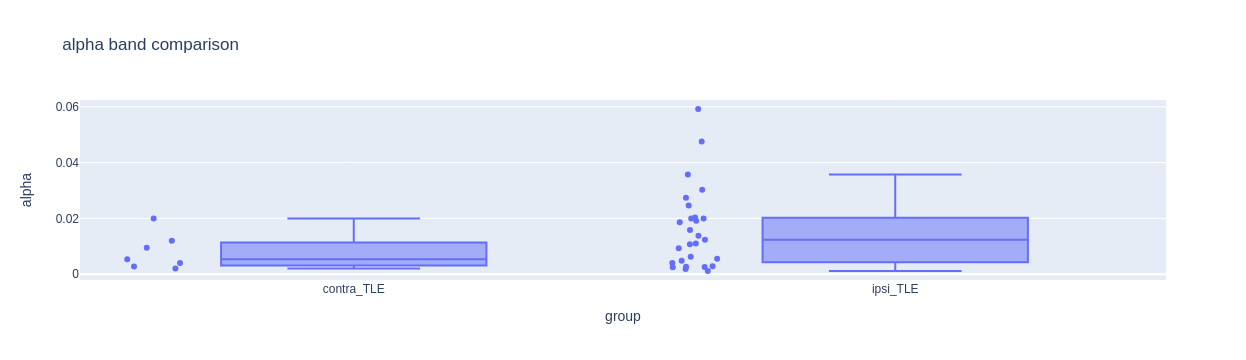

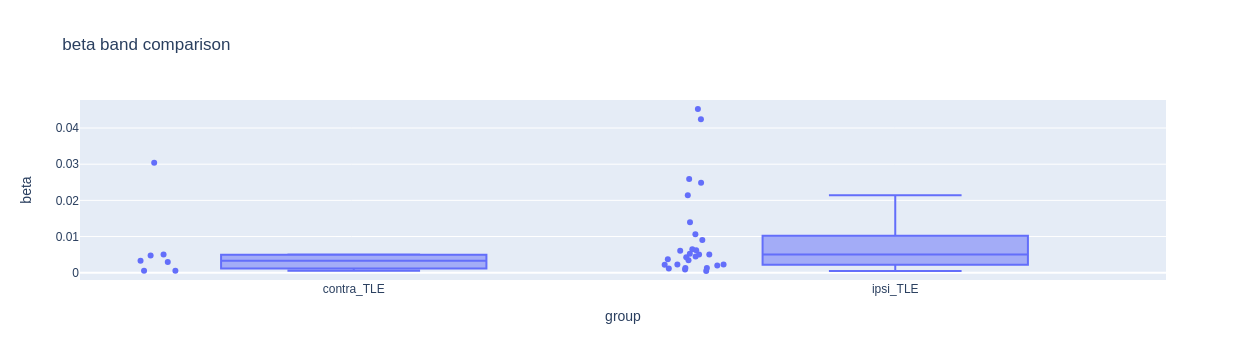

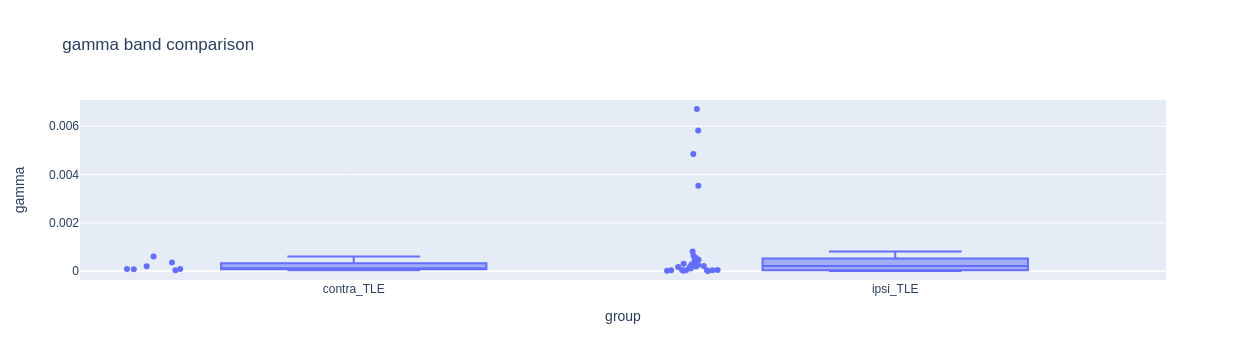

In [29]:
figs=analysis.boxplot_bands_xarray(median_band_corr, 'group', 'f_bands', ["subj_chn"])
for fig, band in zip(figs,list(median_band_corr.f_bands.values)):
    fig.show()
    fig.write_image(f'./Results/{label_test}/corr_band/{band}.png')

In [30]:
p_c, permvals = analysis.permutation_test(median_band_corr, 'group', 
                                          1000, analysis.get_median_diff_no_weights,
                                         dim='f_bands')

Median difference for true labels
Median diff delta: 0.008416871303937423
Median diff theta: -0.00353471025448919
Median diff alpha: -0.0069503605899204225
Median diff beta: -0.0017030178423090405
Median diff gamma: -0.000122556837966695


In [31]:
analysis.eval_significance(p_c, list(median_band_corr.f_bands.values))

Significance without correction
p-val for delta: 0.872
p-val for theta: 0.821
p-val for alpha: 0.317
p-val for beta: 0.37
p-val for gamma: 0.405
Significance with correction (FDR)
corrected p-val for delta: 0.872
corrected p-val for theta: 0.872
corrected p-val for alpha: 0.675
corrected p-val for beta: 0.675
corrected p-val for gamma: 0.675


### Subj level

Median difference for true labels
Median diff delta: -0.030922182256433506
Median diff theta: 0.007292332028192298
Median diff alpha: -0.00036335016673062445
Median diff beta: -0.0012527643047813219
Median diff gamma: -0.0002803778297566812
Significance without correction
p-val for delta: 0.175
p-val for theta: 0.274
p-val for alpha: 0.79
p-val for beta: 0.063
p-val for gamma: 0.259
Significance with correction (FDR)
corrected p-val for delta: 0.3425
corrected p-val for theta: 0.3425
corrected p-val for alpha: 0.79
corrected p-val for beta: 0.315
corrected p-val for gamma: 0.3425


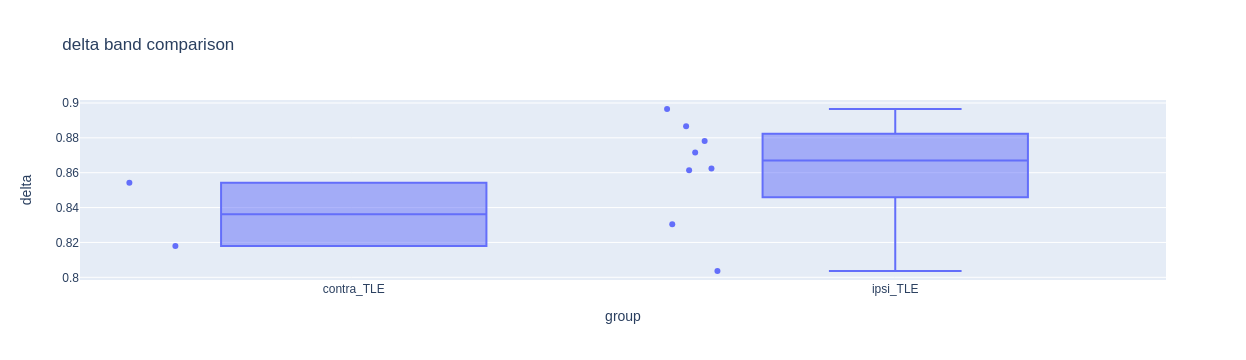

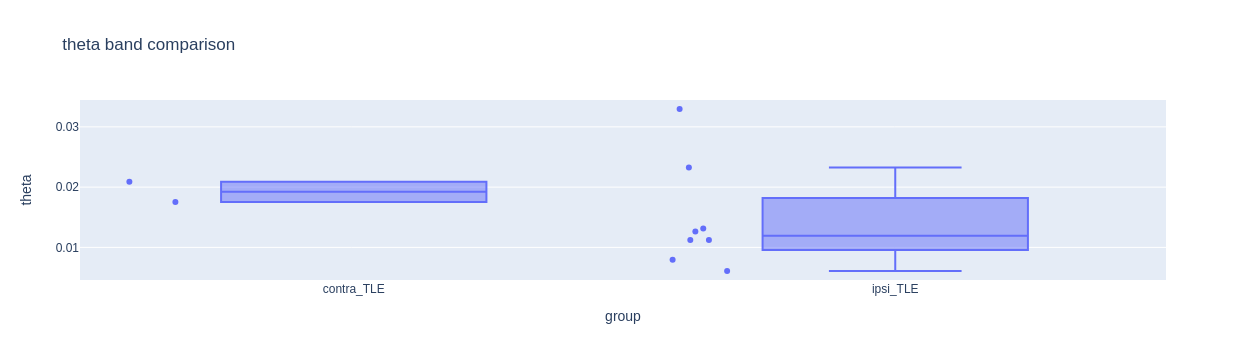

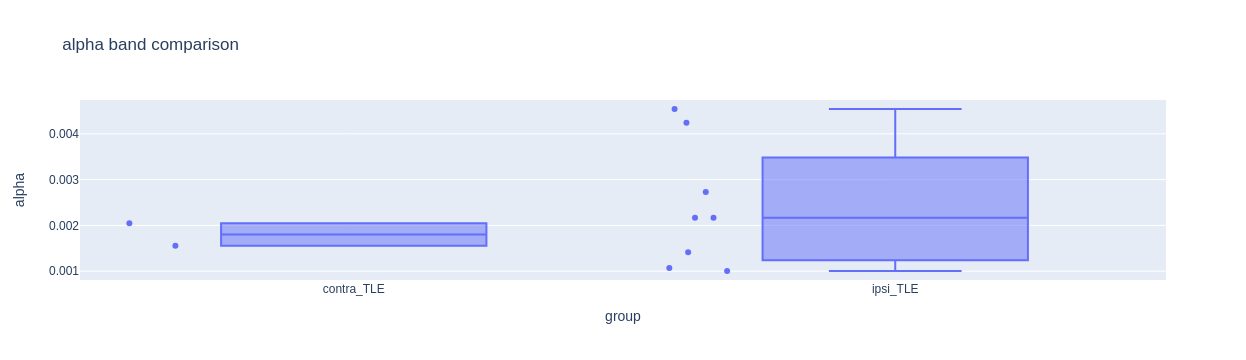

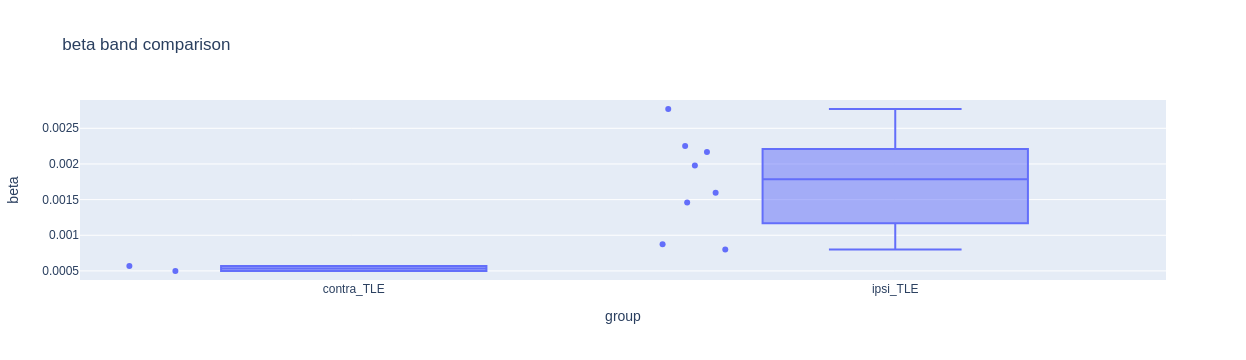

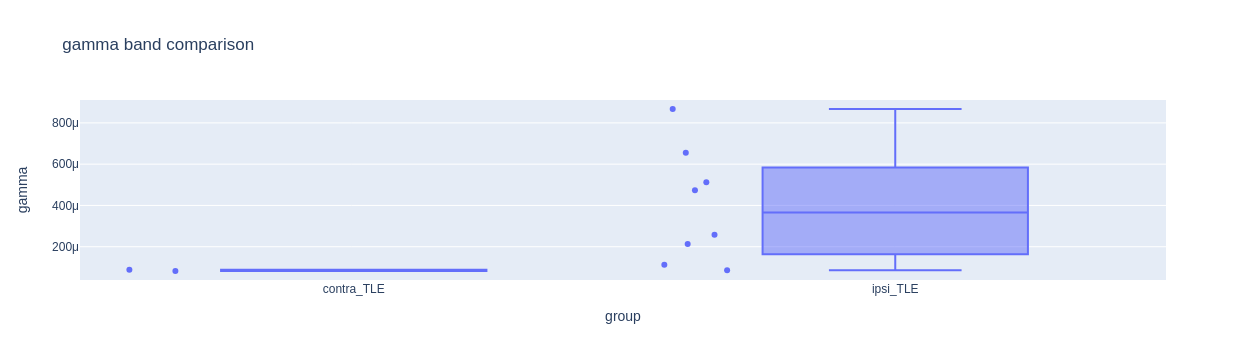

In [32]:
for subj in list(subjs_both)[0:1]:
    array_psd = ds_subj.where(ds_subj['subj']==subj, drop=True)
    # Convert to correlation between clips
    band_correlations = get_correlation_per_band(array_psd, 'subj_ses_run_chn')
    # Get median correlation per channel
    median_band_corr = get_median_corr(band_correlations, 'subj_ses_run_chn')
    # Analyze significant diff
    p_c, permvals = analysis.permutation_test(median_band_corr, 'group', 
                                          1000, analysis.get_median_diff_no_weights,
                                         dim='f_bands')
    analysis.eval_significance(p_c, list(median_band_corr.f_bands.values))
    # Convert to df
    df_corr = median_band_corr.to_dataframe(name='correlation')
    # Plot
    figs=analysis.boxplot_bands_xarray(median_band_corr, 'group', 'f_bands', ["subj_ses_run_chn"])
    for fig, band in zip(figs,list(median_band_corr.f_bands.values)):
        fig.show()
        # fig.write_image(f'./Results/{label_test}/corr_band/{band}.png')

### AP_PD test

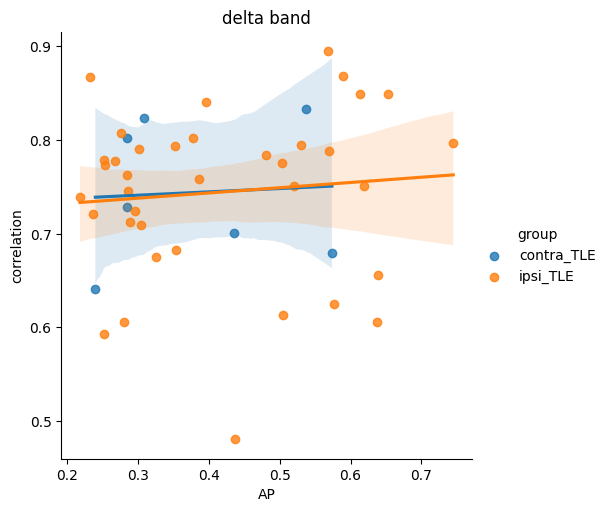

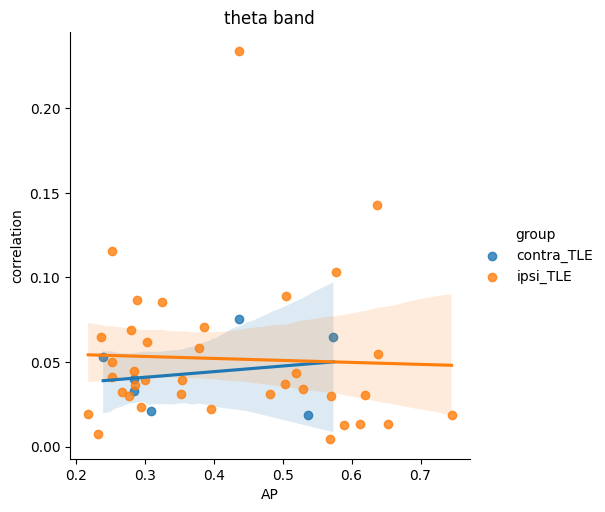

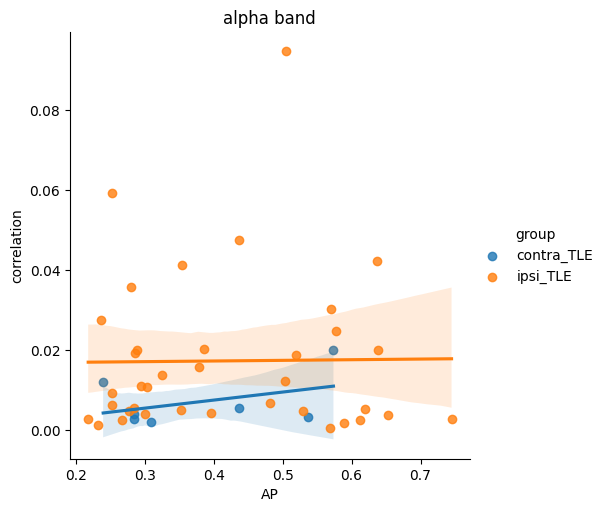

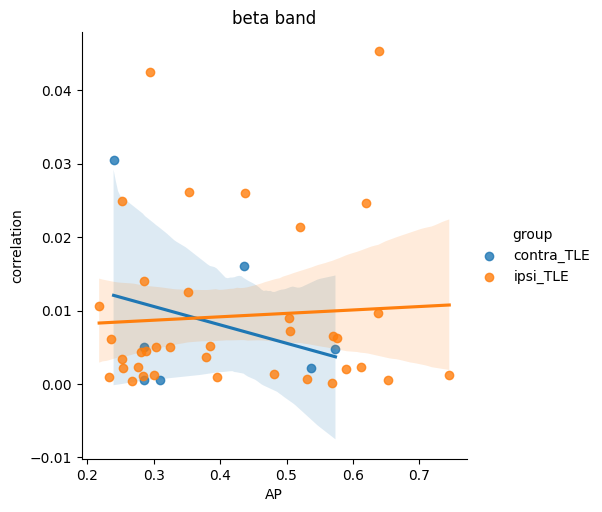

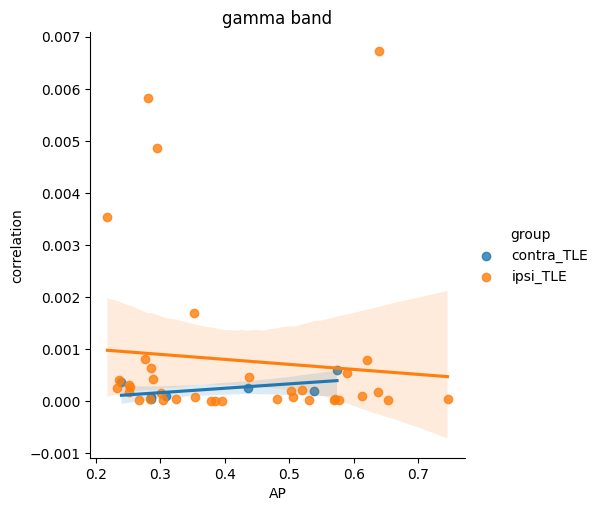

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns
os.makedirs(f'./Results/{label_test}/corr_axis/', exist_ok=True)
for band in median_band_corr['f_bands'].to_numpy():
    df_band = median_band_corr.where(median_band_corr.f_bands==band,drop=True).reset_index(['f_bands']).to_dataframe(name='correlation').reset_index(drop=True)
    sns.lmplot( x = "AP", 
                y = "correlation", 
                hue = "group",
                data = df_band)
    ax = plt.gca()
    ax.set_title(f'{band} band')
    # plt.savefig(f'./Results/{label_test}/corr_axis/{band}_AP.png')

In [33]:
p_c, permvals = analysis.permutation_test(median_band_corr, 'group', 
                                          1000, analysis.get_slope_diff,
                                         dim='f_bands', y='AP')

Median difference for true labels
Median diff delta: -0.2124228714483115
Median diff theta: -18.511056543692792
Median diff alpha: -27.301221613975393
Median diff beta: -88.34105607868838
Median diff gamma: 425.0370248991561


In [34]:
analysis.eval_significance(p_c, list(median_band_corr.f_bands.values))

Significance without correction
p-val for delta: 0.95
p-val for theta: 0.099
p-val for alpha: 0.24
p-val for beta: 0.128
p-val for gamma: 0.834
Significance with correction (FDR)
corrected p-val for delta: 0.95
corrected p-val for theta: 0.32
corrected p-val for alpha: 0.4
corrected p-val for beta: 0.32
corrected p-val for gamma: 0.95


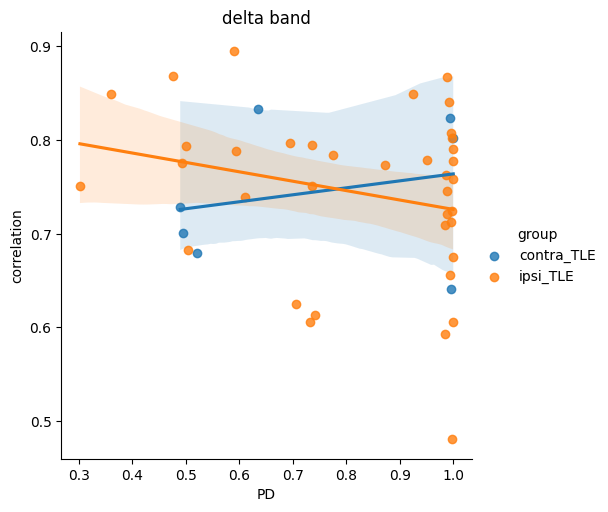

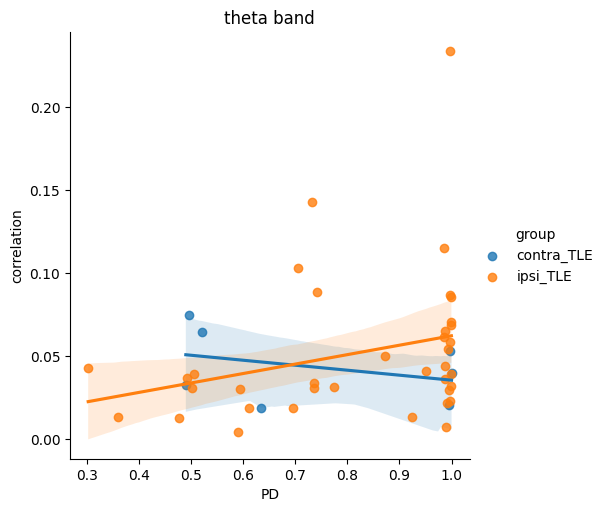

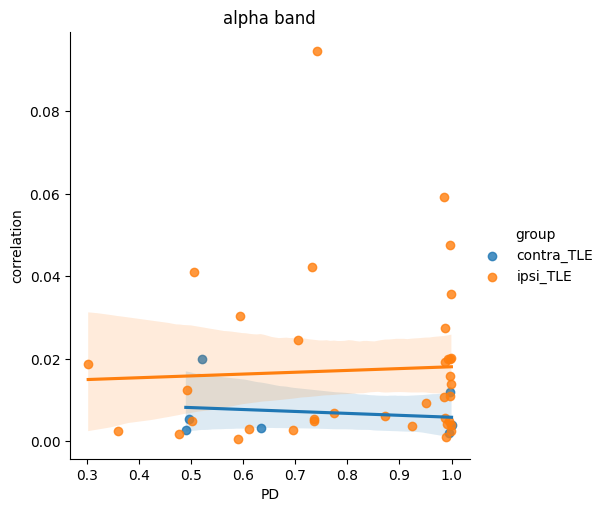

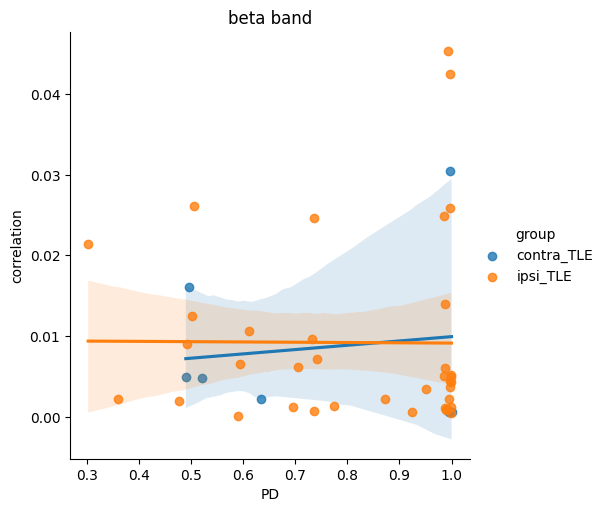

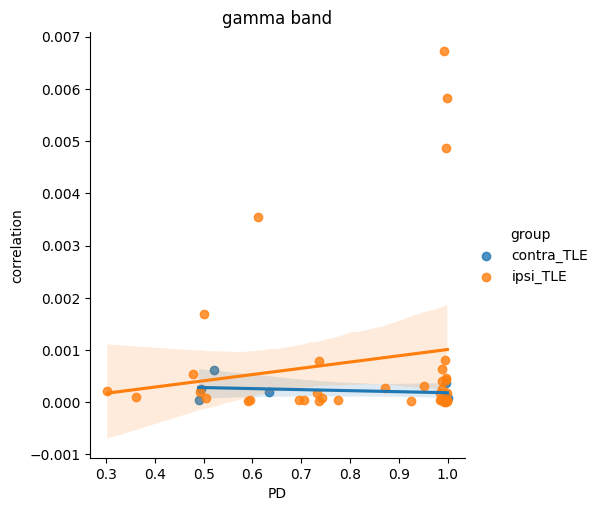

In [113]:
for band in median_band_corr['f_bands'].to_numpy():
    df_band = median_band_corr.where(median_band_corr.f_bands==band,drop=True).reset_index(['f_bands']).to_dataframe(name='correlation').reset_index(drop=True)
    sns.lmplot( x = "PD", 
                y = "correlation", 
                hue = "group",
                data = df_band)
    ax = plt.gca()
    ax.set_title(f'{band} band')
    # plt.savefig(f'./Results/{label_test}/corr_axis/{band}_PD.png')

In [35]:
p_c, permvals = analysis.permutation_test(median_band_corr, 'group', 
                                          1000, analysis.get_slope_diff,
                                         dim='f_bands', y='PD')
analysis.eval_significance(p_c, list(median_band_corr.f_bands.values))

Median difference for true labels
Median diff delta: -2.7213735786512943
Median diff theta: 28.048623891803828
Median diff alpha: 59.74621588150066
Median diff beta: 10.517393949500235
Median diff gamma: -5594.2160619651995
Significance without correction
p-val for delta: 0.768
p-val for theta: 0.156
p-val for alpha: 0.073
p-val for beta: 0.886
p-val for gamma: 0.362
Significance with correction (FDR)
corrected p-val for delta: 0.886
corrected p-val for theta: 0.38999999999999996
corrected p-val for alpha: 0.36499999999999994
corrected p-val for beta: 0.886
corrected p-val for gamma: 0.6033333333333334
